### Ensemble comparison.

In this notebook we implement the 'joint-criteria' ensemble selection method with HAC.

#### Note: refactor functions so that they can be run with a subset of the data (e.g. 80% of patient for sensitivity analysis). Also test with and without parametric-UMAP.


###### Note: currently liking solution with no filtering and these params (and NMI_SCORE='mi' makes no difference):
```SEARCH_TYPE = 'randomized_search'  # we want random parameterisations for diversity.
SAMPLE_SIZE = 200  # number of sample to take from each pipeline to build library 
RUN_IDS_TO_INCLUDE = [1, 2, 5, 6]  # we will reproduce using only kmeans (and including p-umap)
NMI_SCORE = 'norm'  # arg to pass to clustering_similarity method to use partial NMI (ignoring -1 labels from hdbscan) 
SEED = 42```
Gives 5 sensibly sized clusters at t=0.047 (with library t=15.5).


### Note: both with and w/o hdbscan giving small ensembles (2 or 3 members). Worth trying CAS ensemble selection?

In [1]:
import matplotlib.pyplot as plt
import pickle as pk
import pandas as pd
import numpy as np
import wandb
from itertools import combinations
import networkx as nx
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

from utilities import run_configs, load_symptom_data, modularity, clustering_similarity

%matplotlib inline

In [2]:
SEARCH_TYPE = 'randomized_search'  # we want random parameterisations for diversity.
SAMPLE_SIZE = 200  # number of sample to take from each pipeline to build library 
# RUN_IDS_TO_INCLUDE = [1, 2, 5, 6]  # we will reproduce using only kmeans (and including p-umap)
RUN_IDS_TO_INCLUDE = [21]  
NMI_SCORE = 'mi'  # arg to pass to clustering_similarity method to use partial NMI (ignoring -1 labels from hdbscan) 
SEED = 42

In [3]:
np.random.seed(SEED)

In [4]:
run_metadata = {
    'randomized_search': {
        1: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/ndz8b3cz',
            'results_path': 'results/umap_kmeans_silhouette_run_10/all_results.pickle'
        },
        2: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/gcnqmv1k',
            'results_path': 'results/umap_kmeans_dbcv_run_11/all_results.pickle'
        },
        3: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/t0tzp4gz',
            'results_path': 'results/umap_hdbscan_silhouette_run_10/all_results.pickle'
        },
        4: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/zgsa9yi4',
            'results_path': 'results/umap_hdbscan_dbcv_run_11/all_results.pickle'
        },
        5: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/x42hq5ez',
            'results_path': 'results/pca_kmeans_silhouette_run_10/all_results.pickle'
        },
        6: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/qgy8ifuf',
            'results_path': 'results/pca_kmeans_dbcv_run_10/all_results.pickle'
        },
        7: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/en968oqc',
            'results_path': 'results/pca_hdbscan_silhouette_run_10/all_results.pickle'
        },
        8: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/ocncbqca',
            'results_path': 'results/pca_hdbscan_dbcv_run_10/all_results.pickle'
        },
        13: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/lo5r07or',
            'results_path': 'results/parametric_umap_kmeans_silhouette_run_10/all_results.pickle'
        },
        15: {
            'run_path': 'rusty-chris/tune_shallow_clustering/tv9hnbnn',
            'results_path': 'results/parametric_umap_hdbscan_silhouette_run_10/all_results.pickle'
        },
        21: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/lo5r07or',
            'results_path': 'results/umap_kmeans_silhouette_False_1.0_0.8_run_43/all_results.pickle'
        },
#         22: {
#             'run_path': 'rusty-chris/tune_shallow_clustering/tv9hnbnn',
#             'results_path': 'results/umap_kmeans_silhouette_False_0.8_0.8_run_43/all_results.pickle'
#         }
    }
}

#### First we assemble our library of clusterings by selecting from the prior optimisation runs.

In [5]:
for key in run_metadata[SEARCH_TYPE].keys():
    run_configs[key].update(run_metadata[SEARCH_TYPE][key])

In [6]:
def load_results(run_id):
    run_config = run_configs[run_id]
    with open(run_config['results_path'], 'rb') as outfile:
        results = pk.load(outfile)
        
    results = pd.DataFrame.from_dict(results, orient='index')
    results['original_index'] = results.index
    results['run_id'] = run_id
    return results

In [7]:
def filter_results(_results, min_size=2, noise_threshold=0.66):
    _results = _results[_results.cluster_count > min_size]
#     _results = _results[_results.fraction_clustered > noise_threshold]
    
    return _results

In [8]:
def sample_results(_results):
    if len(_results) < SAMPLE_SIZE:
        return _results
    else:
        return _results.sample(SAMPLE_SIZE)

In [9]:
all_results = {
#     run_id: sample_results(filter_results(load_results(run_id)))
#     run_id: sample_results(load_results(run_id))
    run_id: load_results(run_id)
#     for run_id in run_metadata[SEARCH_TYPE].keys()
    for run_id in RUN_IDS_TO_INCLUDE
}

In [15]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [10]:
library = all_results[RUN_IDS_TO_INCLUDE[0]]

In [11]:
def impute_labels(cluster_assignment_dict, symptom_data, knn_impute=False, k=3):
    """
    Method to impute missing labels when patient labelling is incomplete (e.g. when subsampling for robustness
    or when hdbscan labels a patient as -1.)
    
    Default behaviour is to just fill the missing labels with -1 (consistent with hdbscan).
    The alternative, when knn_impute=True is to train a KNN-classifier and use it to predict the 
    missing labels.
    
    Note: 
    
    Args:
        cluster_assignment_dict (dict): an incomplete cluster assignment where keys 
                                        are the patient index from the original (symptom) 
                                        dataframe, and values are the cluster label for that
                                        patient.
                                        
        symptom_data (pandas.DataFrame): the original dataset with only symptom columns retained.
        
        knn_impute (bool): flag, whether to use knn to impute missing labels or just fill with -1
        k (int): number of neighbours for knn-impupter
    """
    
    if knn_impute:
        from sklearn.neighbors import KNeighborsClassifier

        imputer = KNeighborsClassifier(n_neighbors=3)
        imputer.fit(
            symptom_data.loc[cluster_assignment_dict.keys()], 
            list(cluster_assignment_dict.values())
        )

        def impute(patient_symptom_data, imputer=imputer):
            return imputer.predict(patient_symptom_data)
        
    else:
        def impute(patient_symptom_data):
            return -1
        
    return [
        cluster_assignment_dict.get(i, impute(symptom_data.loc[i])) 
        for i in symptom_data.index
    ]

In [24]:
def create_imputed_labels(lib, symptom_data, knn_impute=False, k=3):
    
    imputed_labels = []
    
    for i in range(len(lib)):
        print(i)
        cluster_assignment_dict = dict(zip(
            library.iloc[i].patient_sample_index, library.iloc[i].labels
        ))
        imputed_labels.append(impute_labels(cluster_assignment_dict, symptom_data))  
        
    return imputed_labels

In [ ]:
create_imputed_labels(library, symptom_data, knn_impute=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
np.where(symptom_data.index == 5078)

(array([2884]),)

In [23]:
symptom_data.iloc[2884]

Symptom_Memory_short                  1.0
Symptom_Memory_long                   1.0
Symptom_Memory_no_new_memories        0.0
Symptom_Memory_forget_tasks           0.0
Symptom_Memory_other                  0.0
                                     ... 
Symptom_SkinAllergy_shingles          0.0
Symptom_PEM                           1.0
Symptom_Fatigue                       1.0
Symptom_Change_sensitivity_to_meds    0.0
Symptom_New_allergies                 0.0
Name: 5078, Length: 162, dtype: float64

In [29]:
# symptom_data.loc[cluster_assignment_dict.keys()]

,Symptom_Memory_short,Symptom_Memory_long,Symptom_Memory_no_new_memories,Symptom_Memory_forget_tasks,Symptom_Memory_other,Symptom_Cognitive_Functioning_thinking,Symptom_Cognitive_Functioning_executive,Symptom_Cognitive_Functioning_problemsolving,Symptom_Cognitive_Functioning_slowedthoughts,Symptom_Cognitive_Functioning_fastthoughts,...,Symptom_SkinAllergy_itchy_skin,Symptom_SkinAllergy_itchy_eyes,Symptom_SkinAllergy_heighted_reaction_allergies,Symptom_SkinAllergy_brittle_nail,Symptom_SkinAllergy_other_itchy,Symptom_SkinAllergy_shingles,Symptom_PEM,Symptom_Fatigue,Symptom_Change_sensitivity_to_meds,Symptom_New_allergies
5078,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
3979,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
14020,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,1,0,0
7685,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,1,0,0
101,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0,1,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
10616,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,0
5482,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
8041,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
library = all_results[RUN_IDS_TO_INCLUDE[0]]
for run_id in RUN_IDS_TO_INCLUDE[1:]:
    library = pd.concat(
        [library, all_results[run_id]], ignore_index=True
    )

#### We check how to handle the 80% patient subsamples used in robustness testing for runs 21 and 22:

In [11]:
len(library.labels.iloc[1])

4824

In [12]:
all_results[21].columns

Index(['current_params', 'silhouette', 'dbcv', 'rv', 'calinski_harabasz',
       'davies_bouldin', 'dbcv_minkowski', 'fraction_clustered',
       'cluster_count', 'labels', 'memory', 'verbose', 'umap__a',
       'umap__angular_rp_forest', 'umap__b', 'umap__dens_frac',
       'umap__dens_lambda', 'umap__dens_var_shift', 'umap__densmap',
       'umap__disconnection_distance', 'umap__force_approximation_algorithm',
       'umap__init', 'umap__learning_rate', 'umap__local_connectivity',
       'umap__low_memory', 'umap__metric', 'umap__metric_kwds',
       'umap__min_dist', 'umap__n_components', 'umap__n_epochs',
       'umap__n_jobs', 'umap__n_neighbors', 'umap__negative_sample_rate',
       'umap__output_dens', 'umap__output_metric', 'umap__output_metric_kwds',
       'umap__precomputed_knn', 'umap__random_state',
       'umap__repulsion_strength', 'umap__set_op_mix_ratio', 'umap__spread',
       'umap__target_metric', 'umap__target_metric_kwds',
       'umap__target_n_neighbors', 'umap_

In [14]:
all_results[21]['patient_sample_index']

1       [5078, 3979, 14020, 7685, 101, 3747, 13480, 59...
2       [5078, 3979, 14020, 7685, 101, 3747, 13480, 59...
3       [395, 7418, 3758, 10915, 9326, 107, 4899, 3303...
4       [395, 7418, 3758, 10915, 9326, 107, 4899, 3303...
5       [395, 7418, 3758, 10915, 9326, 107, 4899, 3303...
                              ...                        
996     [7163, 4915, 12515, 2618, 1634, 1356, 9174, 11...
997     [7163, 4915, 12515, 2618, 1634, 1356, 9174, 11...
998     [7163, 4915, 12515, 2618, 1634, 1356, 9174, 11...
999     [7163, 4915, 12515, 2618, 1634, 1356, 9174, 11...
1000    [7163, 4915, 12515, 2618, 1634, 1356, 9174, 11...
Name: patient_sample_index, Length: 1000, dtype: object

In [14]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [17]:
symptom_data

,Symptom_Memory_short,Symptom_Memory_long,Symptom_Memory_no_new_memories,Symptom_Memory_forget_tasks,Symptom_Memory_other,Symptom_Cognitive_Functioning_thinking,Symptom_Cognitive_Functioning_executive,Symptom_Cognitive_Functioning_problemsolving,Symptom_Cognitive_Functioning_slowedthoughts,Symptom_Cognitive_Functioning_fastthoughts,...,Symptom_SkinAllergy_itchy_skin,Symptom_SkinAllergy_itchy_eyes,Symptom_SkinAllergy_heighted_reaction_allergies,Symptom_SkinAllergy_brittle_nail,Symptom_SkinAllergy_other_itchy,Symptom_SkinAllergy_shingles,Symptom_PEM,Symptom_Fatigue,Symptom_Change_sensitivity_to_meds,Symptom_New_allergies
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,1
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,1,0,0,1,1,0,0
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
8,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14158,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1,1,0,1,0,0,1,1,1,0
14161,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1,0,0,0,0,0,1,1,0,0
14163,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,1,0
14166,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### We then produce a final partition from the full library, which will be used to compute diversity and quality metrics...

In [11]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [12]:
df = pd.DataFrame(library.labels)
df = pd.DataFrame(df['labels'].to_list()).transpose()

In [13]:
co_association_matrix = np.zeros([6031, 6031])
n_estimators = len(library)

for ri, row in df.iterrows():
    
    if ri % 500 == 0:
        print(ri)
        
    compare = df.loc[ri + 1:]
    shared_counts = ((row == compare) * (row != -1) * (compare != -1)).sum(axis=1)
    co_association_matrix[ri,ri+1:] = shared_counts / n_estimators

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


In [14]:
distance_matrix = 1 - co_association_matrix

In [15]:
linkage_matrix = hierarchy.linkage(distance_matrix, method='average')

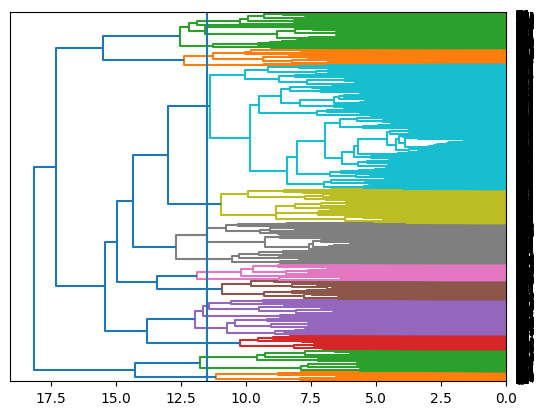

In [16]:
plt.figure()
ax = plt.gca()
dendro_row = hierarchy.dendrogram(linkage_matrix, orientation='left', ax=ax)
ax.axvline(11.5)

In [17]:
clusters = hierarchy.fcluster(linkage_matrix, t=15.5, criterion='distance')

In [18]:
np.unique(clusters, return_counts=True)

(array([1, 2, 3], dtype=int32), array([ 519, 4647,  865]))

#### We now define the Quality and Diversity metrics that will be used for ensemble selection:

In [19]:
def quality(ensemble, library_clustering, score=NMI_SCORE, replace_noise=False):
    """
    Mean of normalized mutual information.
    
    Note: Fern and Lin define 'sum' not 'mean' but this must be wrong?
    """
    return np.mean([
        clustering_similarity(library_clustering, c, score=score, _replace_noise=replace_noise, ignore_label=None)
        for c in ensemble
    ])

In [20]:
quality(library.iloc[0:100].labels, clusters)

0.22672469194943115

In [21]:
def diversity(ensemble,  score=NMI_SCORE, replace_noise=False):
    pairs = list(combinations(ensemble, 2))
    
    return 1 - np.mean([
        clustering_similarity(pair[0], pair[1], score=score, _replace_noise=replace_noise, ignore_label=None)
        for pair in pairs
    ])

In [22]:
diversity(library.iloc[0:20].labels)

0.41697787548258114

#### And the multi-objective criterion that combines them:

In [23]:
def criterion(ensemble, library_clustering, alpha=0.5):
    return (
        alpha * quality(ensemble, library_clustering)
        + (1 - alpha) * diversity(ensemble)
    )

In [24]:
criterion(library.iloc[0:100].labels, clusters)

0.33210303809281483

#### And we now the greedy routine that will optimise the criterion to select the ensemble:

In [25]:
def build_ensemble(library, library_clustering):
    
    ensemble_indices = []
    ensemble = []
    
    # first we select the highest quality clustering
    all_quality = [
        quality([c], library_clustering)
        for c in library
    ]
    best_index = np.argmax(all_quality)
    
    ensemble_indices.append(best_index)
    ensemble.append(library[best_index])
    
    # now we greedily add the clustering that maximises the criterion
    old_best = 0
    while True:
        
        new_scores = [
            criterion(ensemble + [c], library_clustering)
            if i not in ensemble_indices
            else -1
            for i,c in enumerate(library)
        ]
        best_index = np.argmax(new_scores)
        new_best = new_scores[best_index]
        if new_best < old_best:
            break
        else:
            old_best = new_best
            ensemble_indices.append(best_index)
            ensemble.append(library[best_index])
    
    print(old_best)
    return ensemble, ensemble_indices

In [26]:
ensemble, e_indices = build_ensemble(library.labels, clusters)

0.48317838351872444


In [27]:
criterion(ensemble, clusters)

0.48317838351872444

In [28]:
len(ensemble)

2

#### We now have an ensemble of only 2 clusterings!! Hmm...

#### We proceed to try extracting the final set of clusters:

In [29]:
e_indices

[158, 248]

In [30]:
# assert (library.iloc[9].labels == ensemble[0]).all()
# assert (library.iloc[192].labels == ensemble[1]).all()

In [31]:
for ei in e_indices:
    print(np.unique(library.iloc[ei].labels, return_counts=True))

(array([0, 1, 2], dtype=int32), array([2505, 1002, 2524]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18], dtype=int32), array([381, 335, 356, 348, 372, 361, 388, 277, 366, 370, 321, 251, 249,
       253, 309, 194, 336, 234, 330]))


### Final partition:

In [32]:
dff = pd.DataFrame(ensemble).transpose()

In [33]:
fco_association_matrix = np.zeros([6031, 6031])
n_estimators = len(ensemble)

for ri, row in dff.iterrows():
    
    if ri % 500 == 0:
        print(ri)
        
    compare = dff.loc[ri + 1:]
    shared_counts = ((row == compare) * (row != -1) * (compare != -1)).sum(axis=1)
    fco_association_matrix[ri,ri+1:] = shared_counts / n_estimators

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


In [34]:
f_distance_matrix = 1 - fco_association_matrix

In [35]:
f_linkage_matrix = hierarchy.linkage(f_distance_matrix, method='average')

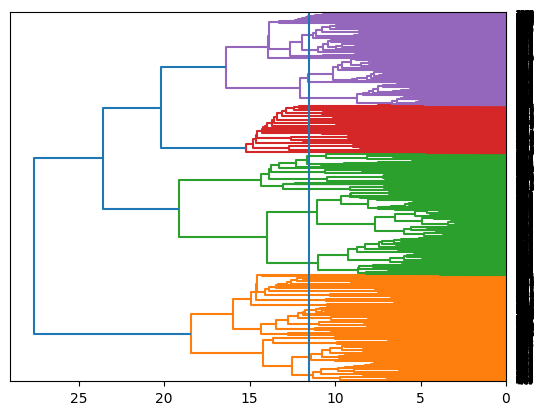

In [36]:
plt.figure()
ax = plt.gca()
dendro_row = hierarchy.dendrogram(f_linkage_matrix, orientation='left', ax=ax)
ax.axvline(11.5)

In [66]:
# final_clusters = hierarchy.fcluster(f_linkage_matrix, t=15, criterion='distance')
# final_clusters = hierarchy.fcluster(f_linkage_matrix, t=7, criterion='maxclust')

In [67]:
vals = np.unique(final_clusters, return_counts=True)
vals

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([ 755,  985, 1358,  632,  782,  767,  752]))

<BarContainer object of 7 artists>

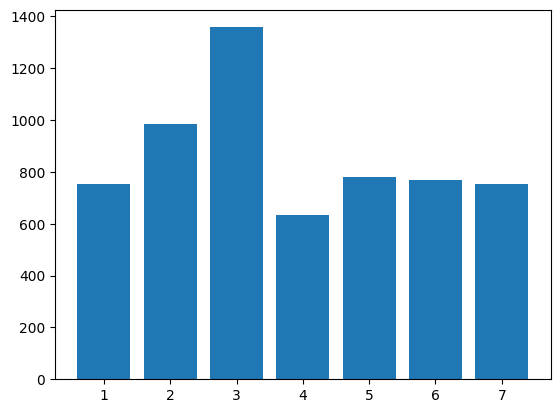

In [68]:
plt.bar(vals[0], vals[1])

In [69]:
adjusted_mutual_info_score(final_clusters, clusters)

0.296525166183637

In [64]:
tessa = pd.read_csv('../clusterings/tessa/cluster_13_111023.csv')
tessa.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

In [65]:
adjusted_mutual_info_score(tessa.cluster, final_clusters)

0.19501616688406764

In [42]:
leo = pd.read_csv('../clusterings/leo/d2_pca_additive_hdbscan_sil_14.csv')

In [43]:
l_comp = [
    c for i,c in enumerate(final_clusters)
    if i in leo['index']
]

In [44]:
adjusted_mutual_info_score(leo.cluster, l_comp)

-6.0628707635233955e-05

In [45]:
import pickle

In [46]:
with open('jc_ensemble_kmeans_final_%d_clusters.pickle' % len(np.unique(final_clusters)), 'wb') as outfile:
    pickle.dump(final_clusters, outfile)